# Analysis of Spatial Transcriptomics enrichment on BRICK

Compared with single-cell transcriptomics, spatial transcriptomics records the spatial location of each cell simultaneously. This enables the analysis of the characteristics of the spatial distribution of different cell types in tissues using spatial transcriptomics. Some biological functions and processes require the joint participation of multiple cell types within the tissue. BRICK can advance the analysis of spatial transcriptomics by querying the spatial relationships between cell tissues to identify cells that truly have anatomical spatial relationships.

## Loading Packages and Data

Here we take a Slide-seq mouse testis dataset as example. [\<Dissecting mammalian spermatogenesis using spatial transcriptomics\>](https://www.cell.com/cell-reports/fulltext/S2211-1247(21)01388-7?uuid=uuid%3Abf78c16a-4834-4054-83a5-aac5ffe8b8f3#sec-4)

In [23]:
#import squidpy as sq
import BRICK
import scanpy as sc

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

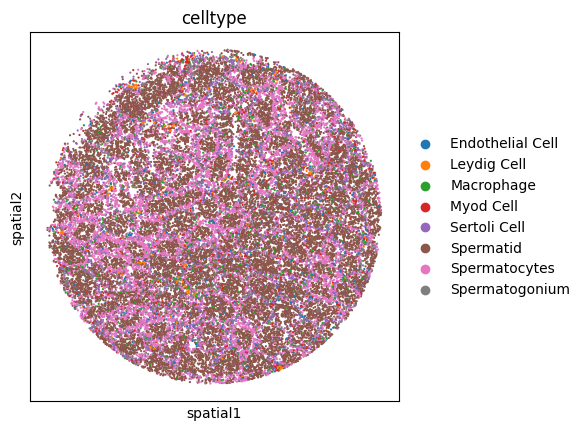

In [27]:
adata_wt = sc.read('./WT1_ct.h5ad')
sc.pl.spatial(adata_wt, color='celltype', spot_size=30)

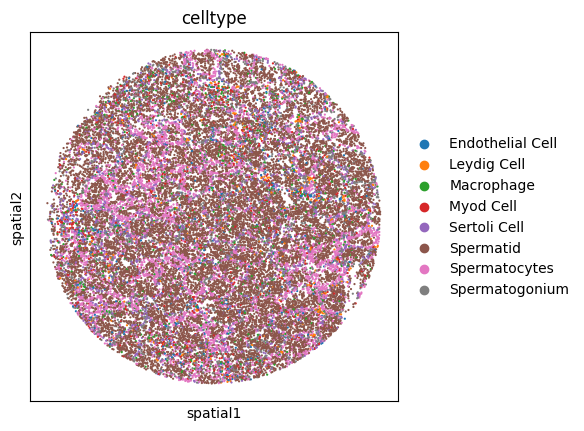

In [29]:
adata_di = sc.read('./Diabetes1_ct.h5ad')
sc.pl.spatial(adata_di, color='celltype', spot_size=30)

## calculate Co-occurrence
Here we use the co-occurrence to study the spatial distribution of celltypes.

In [45]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import networkx as nx
import anndata
from anndata import AnnData
from collections import defaultdict
import time
from sklearn.metrics import pairwise_distances

def co_occurrence_plot(adata, use_col, groups=[], use_key = 'co-occur'):
    if len(groups)==0:
        groups = adata.uns[use_key].keys()
    nrow = int(np.sqrt(len(groups)))
    ncol = np.ceil(len(groups)/nrow).astype(int)
    print(nrow, ncol)
    
    
    fig = plt.figure(figsize=(3*ncol,3*nrow))
    axs = fig.subplots(nrow,ncol)
    
    clust_unique = list(adata.obs[use_col].astype('category').cat.categories)
    ct2color = dict(zip(clust_unique, adata.uns[f'{use_col}_colors']))
    
    for i, g in enumerate(groups):
        interest = adata.uns[use_key][g]
        if nrow == 1:
            if ncol == 1:
                ax = axs
            else:
                ax = axs[i]
        else:
            ax = axs[int(i/ncol)][(i%ncol)]
        for x in interest:
            ax.plot(interest[x], label = x, c=ct2color[x])
        ax.set_title(g)
        ax.legend(fontsize = 7, ncol = max(1, nrow-1), loc='upper right')
    #plt.show()
    return fig

def co_occurrence(adata, use_col, dist_thres = 300, steps = 10, genelist = None, gene_thresh = 0):
    #from collections import defaultdict
    #from scipy import sparse
    from sklearn.metrics import pairwise_distances
    dist_ori = pairwise_distances(adata.obsm['spatial'], adata.obsm['spatial'], metric='euclidean')
    if isinstance(genelist, np.ndarray):
        genelist = list(genelist)
    elif isinstance(genelist, list):
        genelist = genelist
    elif isinstance(genelist, str):
        genelist = [genelist]
    elif isinstance(genelist, int):
        genelist = [genelist]
        
    thresh = np.linspace(0, dist_thres, num=steps+1)   
    out = {}
    for ep in range(thresh.shape[0] - 1):
        thresh_l, thresh_r = thresh[ep], thresh[ep+1]
        dist = dist_ori.copy()
        dist[(dist>=thresh_l)&(dist<thresh_r)]=-1
        dist[dist>-1]=0
        dist[dist==-1]=1
        if genelist is None:
            #df = adata.obs[['Centroid_X', 'Centroid_Y', use_col]]
            count = {x:0 for x in adata.obs[use_col].unique()}
            ret = defaultdict(dict)
            for x in adata.obs[use_col]:
                for y in adata.obs[use_col]:
                    ret[x][y]=0
            for x, y in enumerate(adata.obs[use_col]):
                for z in np.unique(adata.obs[use_col].to_numpy()[dist[x].astype(bool)]):
                    ret[y][z]+=1
                count[y]+=1
            ret=pd.DataFrame(ret)
            ret=ret/count
            out[thresh_r] = ret
        else:
            ret = defaultdict(dict)
            for x in adata.obs[use_col]:
                for y in genelist:
                    ret[x][y]=0
            count = {x:0 for x in adata.obs[use_col].unique()}
            gene_exp_dic ={}
            for z in genelist:
                if sparse.issparse(adata.X):
                    gene_exp=adata[:,z].X.copy().toarray().flatten()
                else:
                    gene_exp=adata[:,z].X.copy().flatten()
                gene_exp[gene_exp<gene_thresh] = 0
                gene_exp_dic[z] = gene_exp
            for x, y in enumerate(adata.obs[use_col]):
                for z in genelist:
                    if (gene_exp_dic[z]*dist[x]).sum()>0:
                        ret[y][z] += 1
                count[y]+=1
            ret=pd.DataFrame(ret)
            ret=ret/count
            out[thresh_r] = ret
    ret = {}
    for x in out[thresh_r].index:
        tmp = {}
        for ep in out:
            tmp[ep] = out[ep].T[x]
        ret[x] = pd.DataFrame(tmp).T
    adata.uns['co-occur_our'] = ret
    return ret


def co_occurrence_heatmap(adata, use_col, dist_min=0, dist_max=10000, use_key = 'co-occur'):
    from seaborn import heatmap
    for tmp in adata.uns[use_key].values():
        break
    groups = [x for x in tmp.index if (x<dist_max)&(x>dist_min)]
    nrow = int(np.sqrt(len(groups)))
    ncol = np.ceil(len(groups)/nrow).astype(int)
    print(nrow, ncol)
    fig = plt.figure(figsize=(9*ncol,8*nrow))
    axs = fig.subplots(nrow,ncol)
    clust_unique = list(adata.obs[use_col].astype('category').cat.categories)
    for i, g in enumerate(groups):
        interest = pd.DataFrame({x:adata.uns[use_key][x].T[g] for x in adata.uns[use_key]})
        #interest = pd.DataFrame({x:adata.uns[use_key][x].T[g] for x in clust_unique})
        if nrow == 1:
            if ncol == 1:
                ax = axs
            else:
                ax = axs[i]
        else:
            ax = axs[int(i/ncol)][(i%ncol)]
        if set(interest.index)==set(clust_unique) and set(interest.columns)==set(clust_unique):
            interest = interest.loc[clust_unique, clust_unique]
        heatmap(interest, ax=ax)
        ax.set_title('{:.4g}'.format(g))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', va = 'top')
        #ax.legend(fontsize = 7, ncol = max(1, nrow-1), loc='upper right')
    plt.show()

2 3


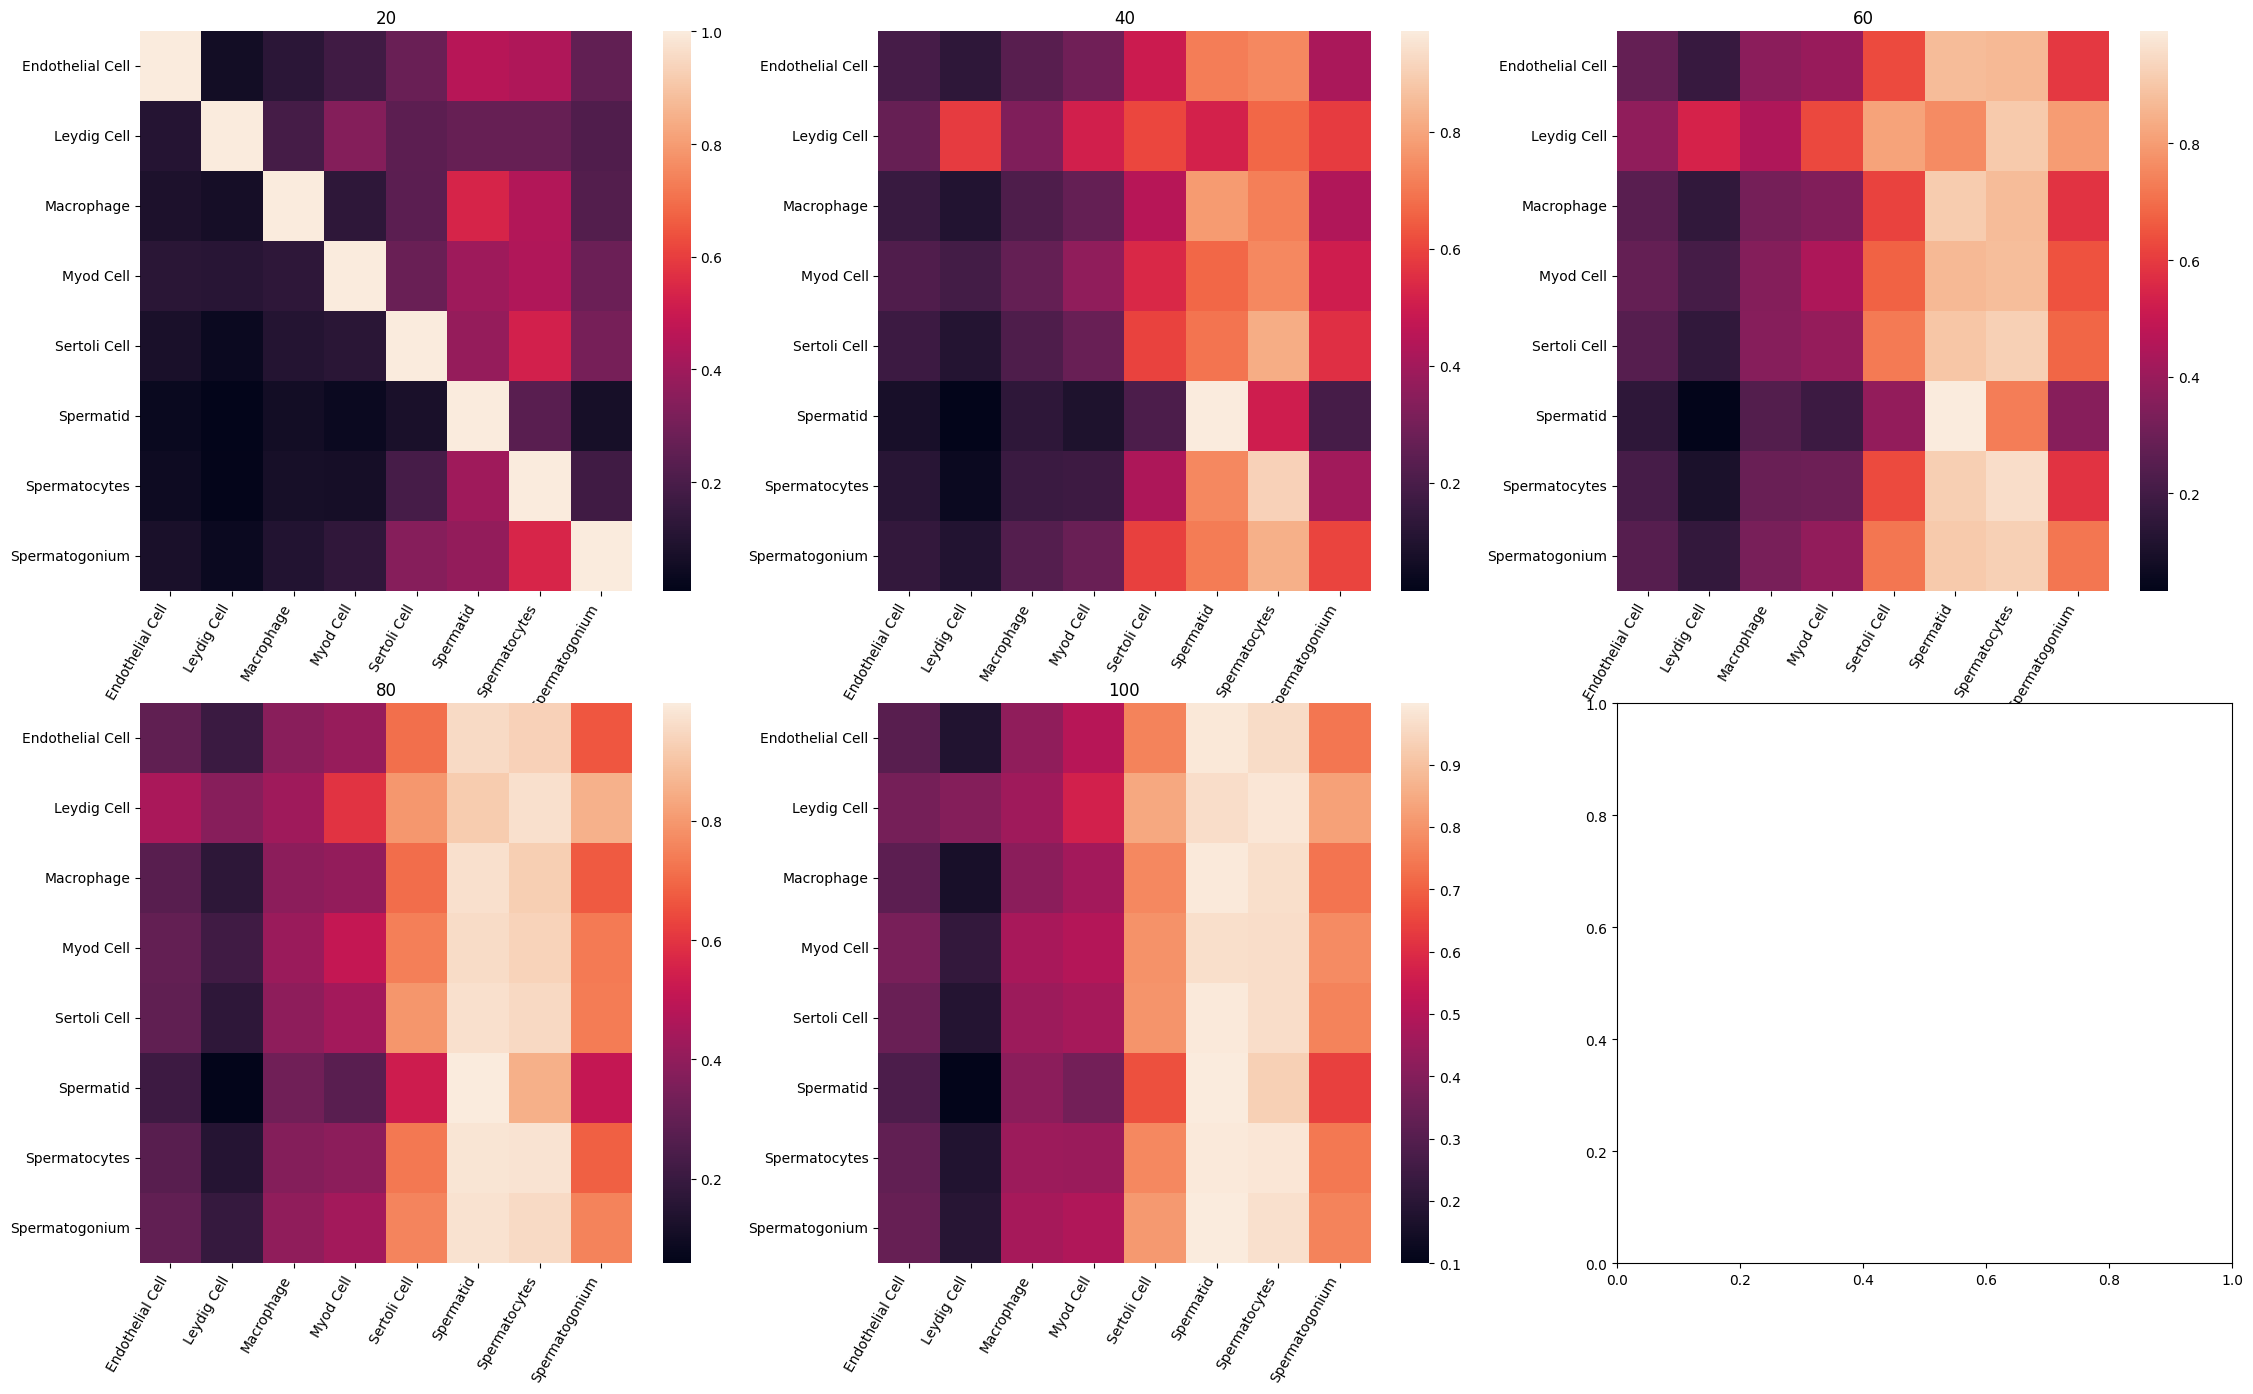

In [38]:
co_occurrence(adata_wt, use_col='celltype')
co_occurrence_heatmap(adata_wt, use_col='celltype', use_key ='co-occur_our')

2 3


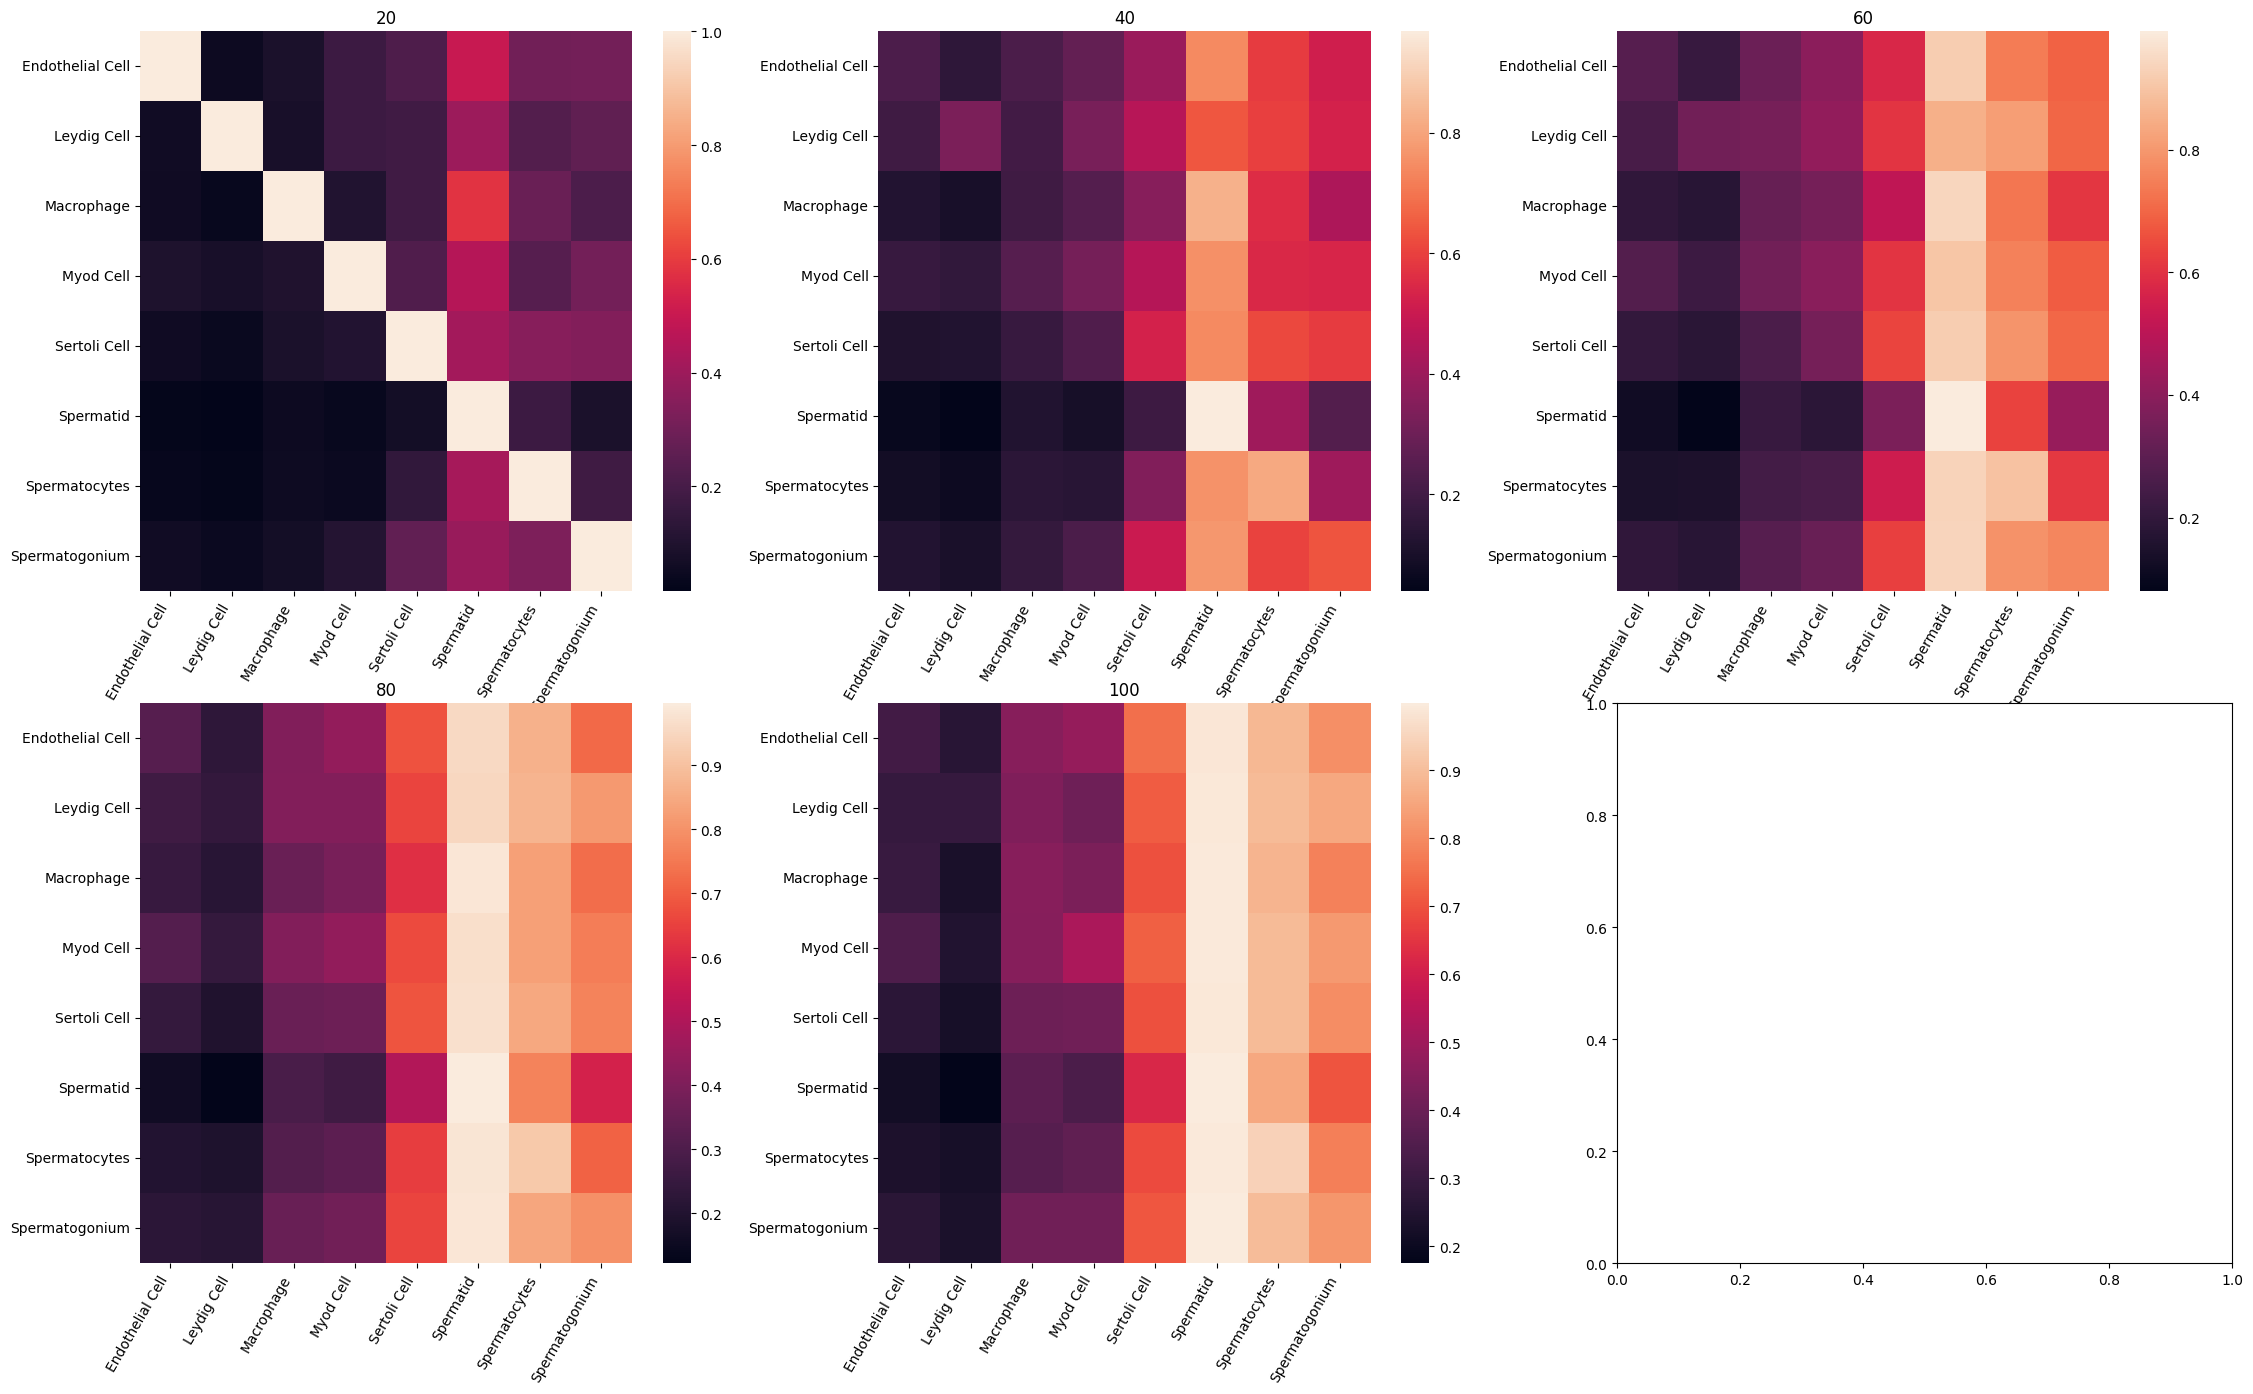

In [40]:
co_occurrence(adata_di, use_col='celltype')
co_occurrence_heatmap(adata_di, use_col='celltype', use_key ='co-occur_our')

## query BRICK to find cells with spatial relationship

In [16]:
cell_list = ['Spermatid', 'Endothelial Cell', 'Leydig Cell', 
             'Macrophage', 'Myod Cell', 'Spermatid',  
             'Sertoli Cell', 'Spermatocytes', 'Spermatogonium']

nxg = BRICK.qr.query_relation(cell_list, 
                              relation=['spatially_related_to', 'is_a'], 
                              multi_hop=3, entity_type=['Cell', 'Tissue'], return_type='graph')

In [21]:
nt = BRICK.pl.interact_visualize_network(nxg, save='spatial.html')
nt.show('spatial.html')

spatial.html
spatial.html


## Discover co-occurrence of Leydig Cell, Sertoli Cell and Spermatogonium

1 1


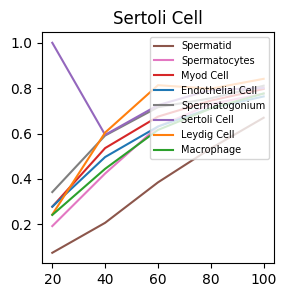

In [47]:
fig = co_occurrence_plot(adata_wt, use_col='celltype', groups=['Sertoli Cell'], use_key = 'co-occur_our')

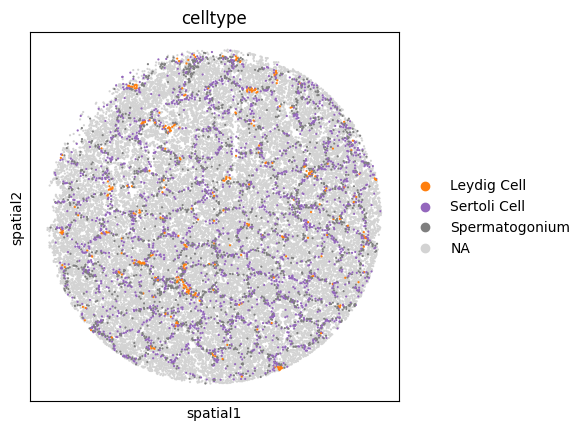

In [44]:
sc.pl.spatial(adata_wt, color = 'celltype', groups = ['Spermatogonium', 'Sertoli Cell', 'Leydig Cell'] ,spot_size = 30)

1 1


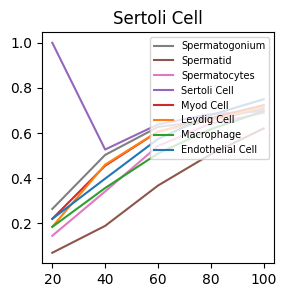

In [48]:
fig = co_occurrence_plot(adata_di, use_col='celltype', groups=['Sertoli Cell'], use_key = 'co-occur_our')

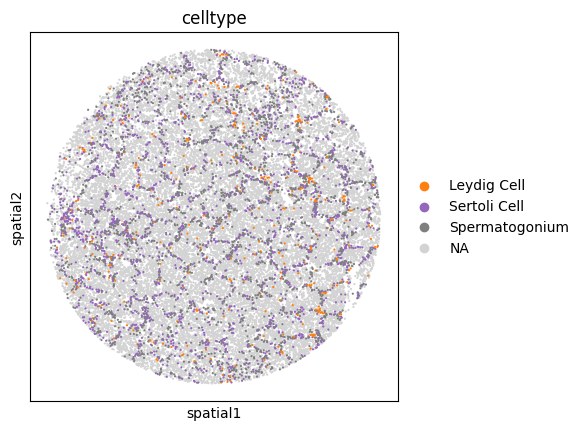

In [43]:
sc.pl.spatial(adata_di, color = 'celltype', groups = ['Spermatogonium', 'Sertoli Cell', 'Leydig Cell'] ,spot_size = 30)